# Kernel density estimation (KDE)

The following code has been adapted from Till A. Hoffmann.

See https://nbviewer.jupyter.org/gist/tillahoffmann/f844bce2ec264c1c8cb5
and https://stackoverflow.com/questions/27623919/weighted-gaussian-kernel-density-estimation-in-python

In [117]:
%matplotlib inline

In [118]:
import os, sys
sys.path.append(os.path.abspath('../../main/python'))

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import thalesians.tsa.distrs as distrs
import thalesians.tsa.kde as kde

import importlib
importlib.reload(distrs)
importlib.reload(kde)

<module 'thalesians.tsa.kde' from 'C:\\Users\\Paul\\Documents\\dev\\tsa\\src\\main\\python\\thalesians\\tsa\\kde.py'>

## Unweighted, one-dimensional

empirical_distr mean [[-0.02848745]]
gaussian_kde_distr mean [[-0.02848745]]


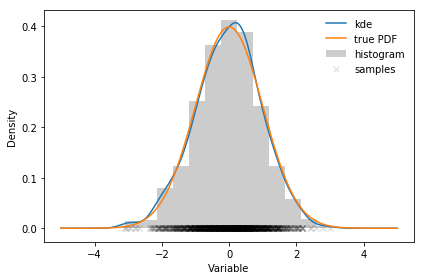

In [119]:
#Define parameters
num_samples = 1000
xmax = 5
bins=21

#Generate equal-weighted samples
samples = np.random.normal(size=num_samples)
weights = np.ones(num_samples) / num_samples
empirical_distr = distrs.EmpiricalDistr(particles=samples, weights=weights)
print('empirical_distr mean', empirical_distr.mean)

#Plot a histogram
plt.hist(empirical_distr.particles, bins, (-xmax, xmax), histtype='stepfilled', alpha=.2, density=True, color='k', label='histogram')

#Construct a KDE and plot it
gaussian_kde_distr = kde.GaussianKDEDistr(empirical_distr)
print('gaussian_kde_distr mean', gaussian_kde_distr.mean)
x = np.linspace(-xmax, xmax, 200)
y = gaussian_kde_distr.pdf(x)
plt.plot(x, y, label='kde')
#Plot the samples
plt.scatter(samples, np.zeros_like(samples), marker='x', color='k', alpha=.1, label='samples')

#Plot the true pdf
y = stats.norm().pdf(x)
plt.plot(x,y, label='true PDF')

#Boiler plate
plt.xlabel('Variable')
plt.ylabel('Density')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

## Weighted, one-dimensional

empirical_distr mean [[-0.35376136]]
gaussian_kde_distr mean [[-0.35376136]]


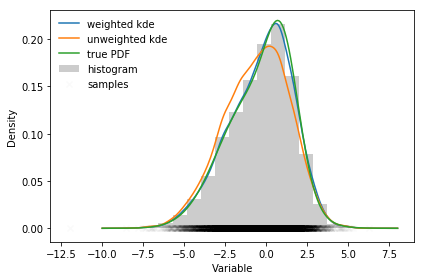

In [120]:
bins = 21

#Define a Gaussian mixture to draw samples from
num_samples = 10000
xmin, xmax = -10, 8
#Weight attributed to each component of the mixture
gaussian_weights = np.array([2, 1], dtype=np.float)
gaussian_weights /= np.sum(gaussian_weights)
#Mean and std of each mixture
gaussian_means = np.array([-1, 1])
gaussian_std = np.array([2, 1])
#Observation probability of each mixture
gaussian_observation = np.array([1, .5])

#How many samples belong to each mixture?
gaussian_samples = np.random.multinomial(num_samples, gaussian_weights)
samples = []
weights = []
#Generate samples and observed samples for each mixture component
for n, m, s, o in zip(gaussian_samples, gaussian_means, gaussian_std, gaussian_observation):
    _samples = np.random.normal(m, s, n)
    _samples = _samples[o > np.random.uniform(size=n)]
    samples.extend(_samples)
    weights.extend(np.ones_like(_samples) / o)

#Renormalise the sample weights
weights = np.array(weights, np.float)
weights /= np.sum(weights)
samples = np.array(samples)

#Compute the true pdf
x = np.linspace(xmin, xmax, 200)
true_pdf = 0
for w, m, s in zip(gaussian_weights, gaussian_means, gaussian_std):
    true_pdf = true_pdf + w * stats.norm(m, s).pdf(x)

#Plot a histogram
plt.hist(samples, bins, (xmin, xmax), histtype='stepfilled', alpha=.2, density=True, color='k', label='histogram', weights=weights)

#Construct a KDE and plot it
empirical_distr = distrs.EmpiricalDistr(particles=samples, weights=weights)
gaussian_kde_distr = kde.GaussianKDEDistr(empirical_distr)
print('empirical_distr mean', empirical_distr.mean)
print('gaussian_kde_distr mean', gaussian_kde_distr.mean)
y = gaussian_kde_distr.pdf(x)
plt.plot(x, y, label='weighted kde')

#Compare with a naive kde
pdf = stats.gaussian_kde(samples)
y = pdf(x)
plt.plot(x, y, label='unweighted kde')

#Plot the samples
plt.scatter(samples, np.zeros_like(samples), marker='x', color='k', alpha=.02, label='samples')

#Plot the true pdf
plt.plot(x,true_pdf, label='true PDF')

#Boiler plate
plt.xlabel('Variable')
plt.ylabel('Density')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

## Weighted, two-dimensional

empirical_distr mean [[-0.30959295]
 [-0.31633695]]
gaussian_kde_distr mean [[-0.30959295]
 [-0.31633695]]


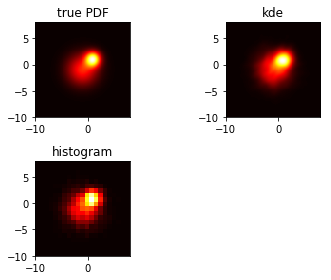

In [121]:
bins = 21

#Define a Gaussian mixture to draw samples from
num_samples = 10000
xmin, xmax = -10, 8
#Weight attributed to each component of the mixture
gaussian_weights = np.array([2, 1], dtype=np.float)
gaussian_weights /= np.sum(gaussian_weights)
#Mean and std of each mixture
gaussian_means = np.array([-1, 1])
gaussian_std = np.array([2, 1])
#Observation probability of each mixture
gaussian_observation = np.array([1, .5])

#How many samples belong to each mixture?
gaussian_samples = np.random.multinomial(num_samples, gaussian_weights)
samples = []
weights = []
#Generate samples and observed samples for each mixture component
for n, m, s, o in zip(gaussian_samples, gaussian_means, gaussian_std, gaussian_observation):
    _samples = np.random.normal(m, s, (n, 2))
    _samples = _samples[o > np.random.uniform(size=n)]
    samples.extend(_samples)
    weights.extend(np.ones(len(_samples)) / o)

#Renormalise the sample weights
weights = np.array(weights, np.float)
weights /= np.sum(weights)
samples = np.transpose(samples)
#Evaluate the true pdf on a grid
x = np.linspace(xmin, xmax, 100)
xx, yy = np.meshgrid(x, x)
true_pdf = 0
for w, m, s in zip(gaussian_weights, gaussian_means, gaussian_std):
    true_pdf = true_pdf + w * stats.norm(m, s).pdf(xx) * stats.norm(m, s).pdf(yy)
#Evaluate the kde on a grid
empirical_distr = distrs.EmpiricalDistr(particles=samples.T, weights=weights)
gaussian_kde_distr = kde.GaussianKDEDistr(empirical_distr)
print('empirical_distr mean', empirical_distr.mean)
print('gaussian_kde_distr mean', gaussian_kde_distr.mean)
points = (np.ravel(xx), np.ravel(yy))
points = np.array(points).T
zz = gaussian_kde_distr.pdf(points)
zz = np.reshape(zz, xx.shape)
kwargs = dict(extent=(xmin, xmax, xmin, xmax), cmap='hot', origin='lower')
#Plot the true pdf
plt.subplot(221)
plt.imshow(true_pdf.T, **kwargs)
plt.title('true PDF')

#Plot the kde
plt.subplot(222)
plt.imshow(zz.T, **kwargs)
plt.title('kde')
plt.tight_layout()

#Plot a histogram
ax = plt.subplot(223)
plt.hist2d(samples[0], samples[1], bins, ((xmin, xmax), (xmin, xmax)), True, weights, cmap='hot')
ax.set_aspect(1)
plt.title('histogram')
plt.tight_layout()
plt.show()